<h1> Tasa de Desempleo de EEUU </h1>
<hr>

Para el desarrollo de este proyecto, se realizó la descarga de la base de datos. Se tomó desde Enero de 1948 hasta Diciembre de 2019. Aunque el assement decía que era hasta el 2017, se tomaron 2 años de más para ver que tan buenas serían las predicciones acorde a los modelos que se implementarán. A continuación realizamos la carga de los modulos implementados para este análisis:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
import datetime as dt
import re
import warnings
warnings.filterwarnings("ignore")

from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

Cargadas las librerías a utilizar, se procede a cargar la información que se requiere:

In [2]:
df = pd.read_csv("UNRATE.csv")
df["DATE"] = pd.DatetimeIndex(df["DATE"].apply(lambda x: dt.datetime.strptime(x, "%Y-%m-%d")))
df["MES"]  = df.reset_index()["DATE"].apply(lambda x: x.month)
df["ANIO"]  = df.reset_index()["DATE"].apply(lambda x: x.year)
df["UNRATE_DIFF"] = df["UNRATE"].diff()
df_test = df.query("ANIO > 2017")
df = df.query("ANIO <=2017").set_index("DATE")
df.head()

,UNRATE,MES,ANIO,UNRATE_DIFF
DATE,,,,
1948-01-01,3.4,1,1948,NaN
1948-02-01,3.8,2,1948,0.4
1948-03-01,4.0,3,1948,0.2
1948-04-01,3.9,4,1948,-0.1
1948-05-01,3.5,5,1948,-0.4


A continuación se realiza un gráfico para visualizar los gráficos que se manejarán. En la parte superior del gráfico se tendrá la serie de tiempo del desempleo tal cual se está observando, en la parte inferior se tendrán dos gráficos. Uno, que presenta los valores de la tasa de desempleo por mes y año, y el otro, presenta cómo se ha comportado esta variable teniendo en cuenta cada unos de sus meses y sus medias.

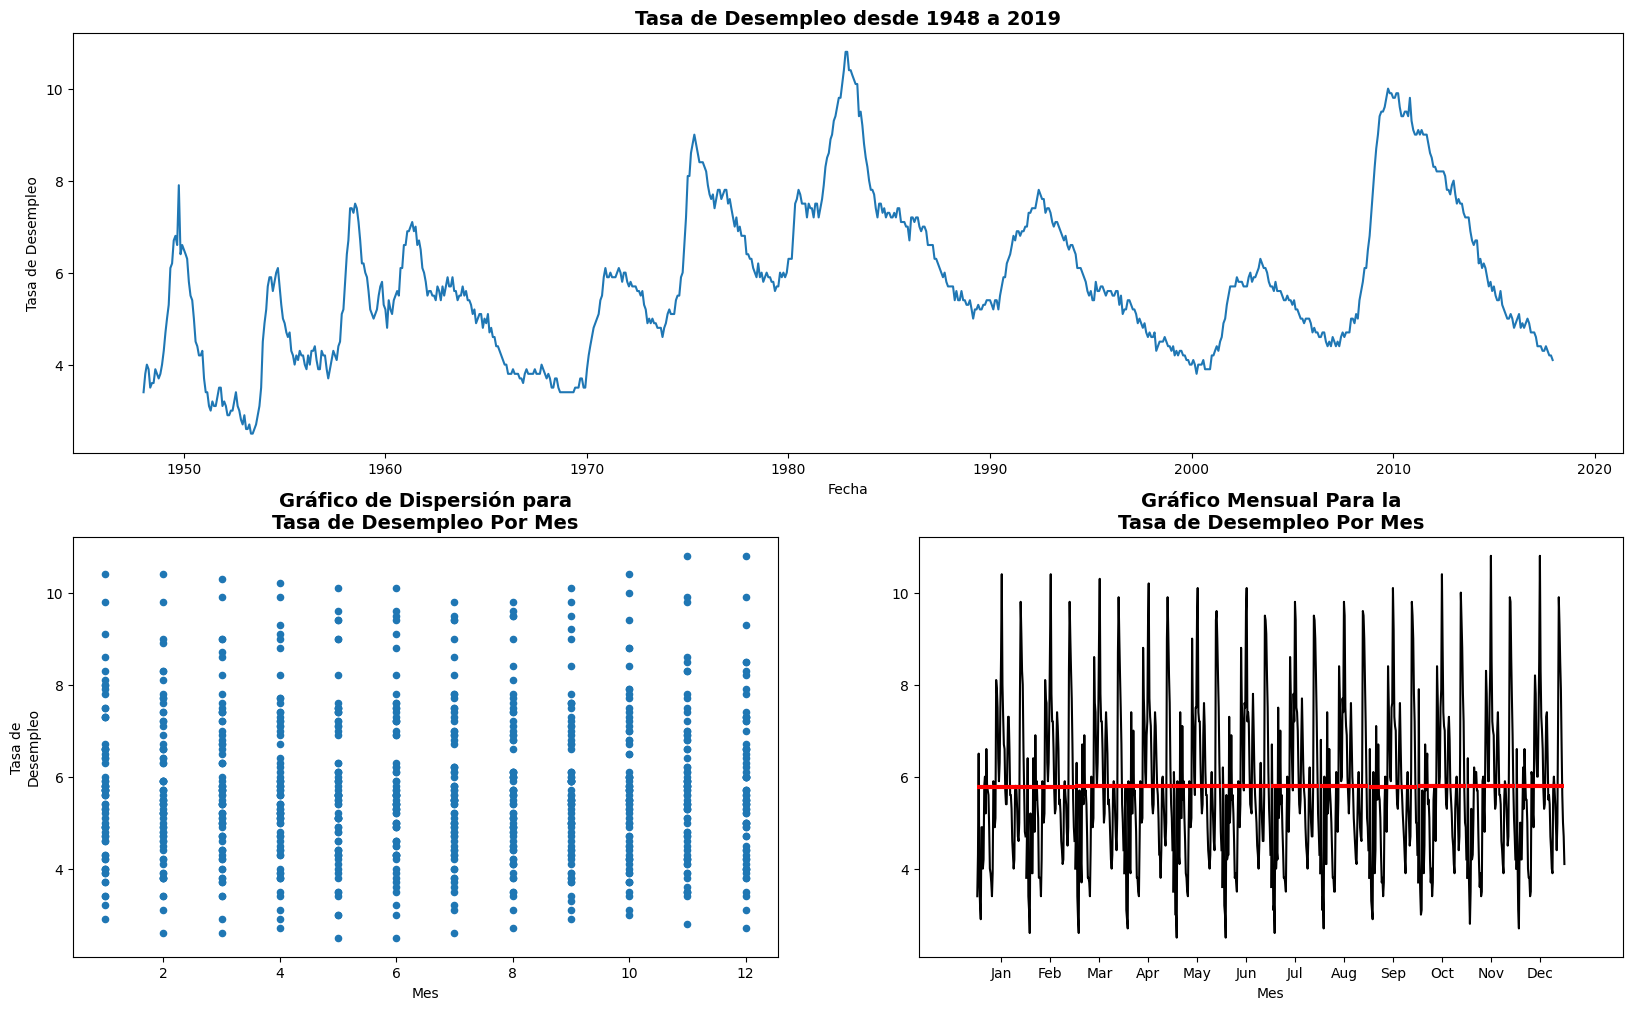

In [3]:
mosaic = [["A", "A"],
          ["B", "C"]]

plt.rc("axes", labelsize = 10, titlesize = 14)
plt.rc("xtick", labelsize = 10)
plt.rc("ytick", labelsize = 10)

fig, ax = plt.subplot_mosaic(mosaic, figsize = (20, 12))

ax["A"].plot(df.reset_index()["DATE"],df["UNRATE"])
ax["A"].set_title("Tasa de Desempleo desde 1948 a 2019", fontweight = "bold")
ax["A"].set_xlabel("Fecha")
ax["A"].set_ylabel("Tasa de Desempleo")

(
    df.
    groupby(["MES", "ANIO"]).
    agg(
        UNRATE = ("UNRATE", "mean")
    ).
    reset_index().
    plot(x = "MES", y = "UNRATE", kind="scatter", ax = ax["B"])
)

ax["B"].set_title("Gráfico de Dispersión para\nTasa de Desempleo Por Mes", fontweight = "bold")
ax["B"].set_xlabel("Mes")
ax["B"].set_ylabel("Tasa de\nDesempleo")

ax["C"].set_title("Gráfico Mensual Para la\nTasa de Desempleo Por Mes", fontweight = "bold")
ax["C"].set_xlabel("Mes")
ax["C"].set_ylabel("Tasa de\nDesempleo")

sm.graphics.tsa.month_plot(df[["UNRATE"]], ax = ax["C"])
plt.show()

Para responder la primera pregunta, se tiene lo siguiente. Cuando se trabaja con series de tiempo se suele aplicar una descomposición en dos partes:

<ol>
<li><strong>Tendencia</strong>: Esta hace referencia al comportamiento general de la serie de tiempo, es decir, al analizar de manera global los datos, si presentan algún comportamiento específico. </li>
<li><strong>Estacional</strong>: Este hace referencia al comportamiento que se puede presentar de manera cíclica a lo largo del perido. En este caso no nos centramos en ver cómo se comporta de manera general los datos sino nos enfocamos en periodos de tiempo en los cuales se puedan presentar patrones.
</ol>

El siguiente gráfico presenta el comportamiento de la serie de tiempo, incluyendo la tendencia y aparte cómo es la estacionalidad junto con sus residuos. Cabe mencionar que el modelo implementado es aditivo:

$$y_t = \tau_t + S_t + R_t $$

El término $y_t$ hace referencia al valor de la variable observada, $\tau$ es el valor de la tendencia, $S$ es la estacionalidad y $R$ es el  valor del residuo en el tiempo $t$.


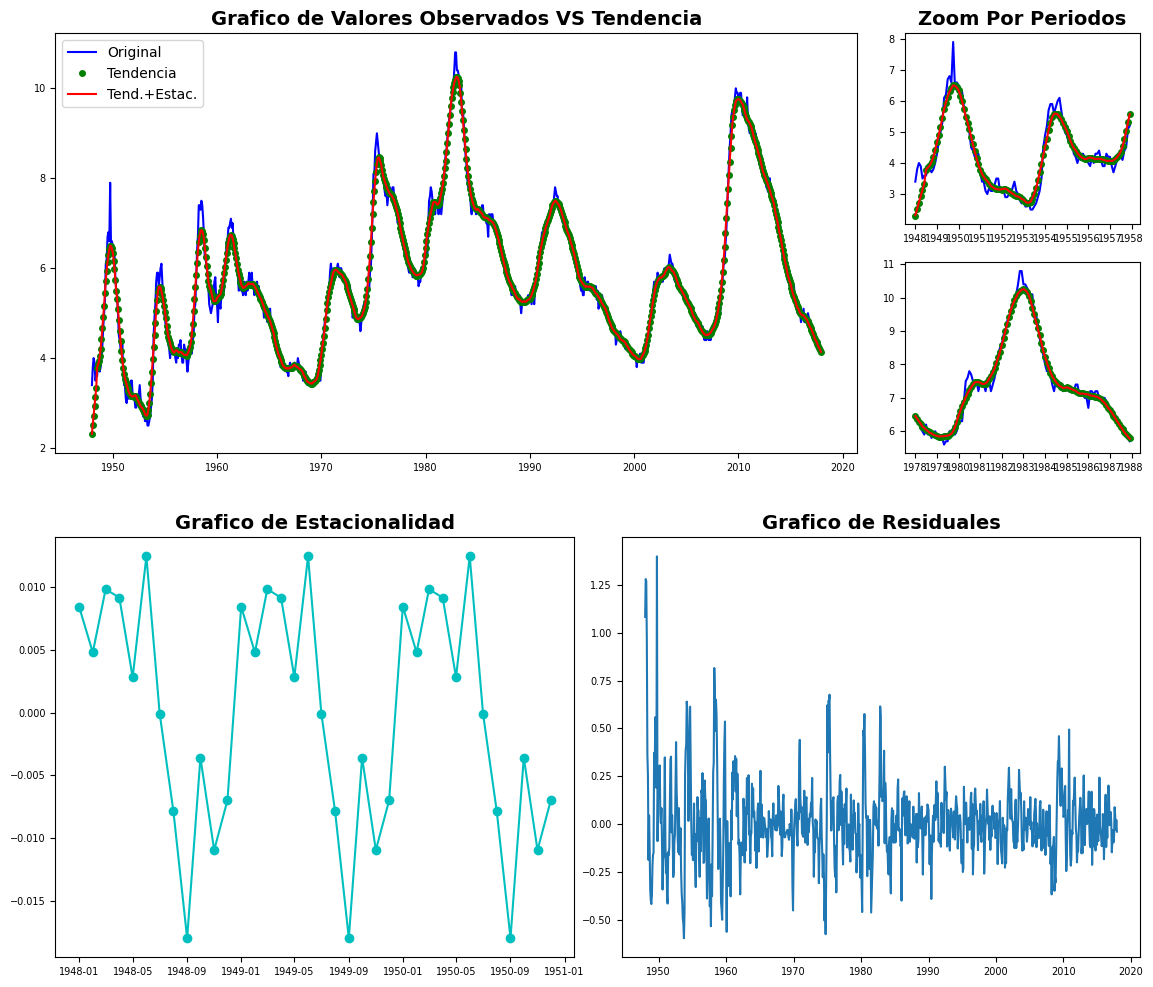

In [4]:
md = seasonal_decompose(df[["UNRATE"]], model="additive", period=12, extrapolate_trend='freq')

plt.rc("axes", labelsize = 7, titlesize=14) 
plt.rc("xtick", labelsize = 7) 
plt.rc("ytick", labelsize = 7) 

mosaic = [["A", "A", "A", [["A1"], ["A2"]]],
          ["C", "C", "D", "D"]]
fig, ax = plt.subplot_mosaic(mosaic, figsize = (14,12))

ax["A"].plot(md.observed, "b")
ax["A"].plot(md.trend, "go", markersize = 4)
ax["A"].plot(md.trend+md.seasonal, "r-")
ax["A"].legend(labels = ["Original", "Tendencia", "Tend.+Estac."])

ax["A1"].plot(md.observed[0:120], "b")
ax["A1"].plot(md.trend[0:120], "go", markersize = 4)
ax["A1"].plot(md.trend[0:120]+md.seasonal[0:120], "r-")

ax["A2"].plot(md.observed[360:480], "b")
ax["A2"].plot(md.trend[360:480], "go", markersize = 4)
ax["A2"].plot(md.trend[360:480]+md.seasonal[360:480], "r")

ax["C"].plot(md.seasonal[0:36], "c")
ax["C"].plot(md.seasonal[0:36], "co")
ax["D"].plot(md.resid)

ax["A"].set_title("Grafico de Valores Observados VS Tendencia", fontweight = "bold")
ax["A1"].set_title("Zoom Por Periodos", fontweight = "bold")
ax["C"].set_title("Grafico de Estacionalidad", fontweight = "bold")
ax["D"].set_title("Grafico de Residuales", fontweight = "bold")

plt.show()

Entre los meses de Enero a Julio se presenta una impacto positivo en la tendencia, algunos meses como Enero, Marzo y Junio presentan el mayor aumento de la Tasa de Desempleo. Para los meses posteriores a Julio, se observa un impacto negativo en la Tasa de Desempleo, es decir, para estos meses la Tasa de Desempleo tiende a Decrecer, siendo el mes de Septiembre el que tiene mayor impacto. 

Para visualizar un poco más a profundidad a qué se hace refente la tendecia y la estacionalidad, el siguiente gráfico presenta los resultados obtenidos pero teniendo un perido de 10 años:

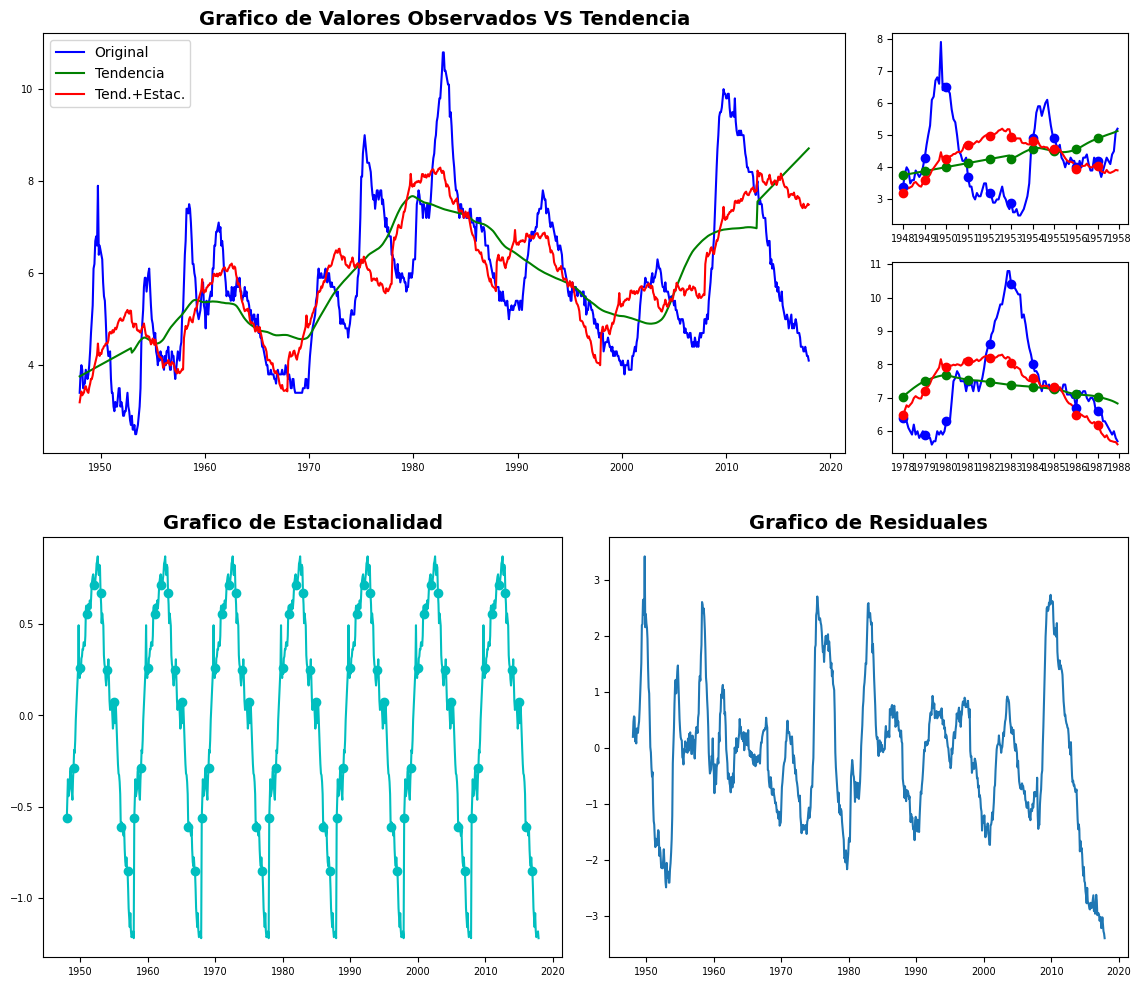

In [5]:
md_1 = seasonal_decompose(df[["UNRATE"]], model="additive", period=120, extrapolate_trend='freq')

plt.rc("axes", labelsize = 7, titlesize=14) 
plt.rc("xtick", labelsize = 7)
plt.rc("ytick", labelsize = 7) 

mosaic = [["A", "A", "A", [["A1"], ["A2"]]],
          ["C", "C", "D", "D"]]
fig, ax = plt.subplot_mosaic(mosaic, figsize = (14,12))

ax["A"].plot(md_1.observed, "b")
ax["A"].plot(md_1.trend, "g")
ax["A"].plot(md_1.trend+md_1.seasonal, "r")
ax["A"].legend(labels = ["Original", "Tendencia", "Tend.+Estac."])

ax["A1"].plot(md_1.observed[0:120], "b")
ax["A1"].plot(md_1.trend[0:120], "g")
ax["A1"].plot(md_1.trend[0:120]+md_1.seasonal[0:120], "r")

ax["A1"].plot(md_1.observed[range(0,120,12)], "bo")
ax["A1"].plot(md_1.trend[range(0,120,12)], "go")
ax["A1"].plot(md_1.trend[range(0,120,12)]+md_1.seasonal[range(0,120,12)], "ro")

ax["A2"].plot(md_1.observed[360:480], "b")
ax["A2"].plot(md_1.trend[360:480], "g")
ax["A2"].plot(md_1.trend[360:480]+md_1.seasonal[360:480], "r")

ax["A2"].plot(md_1.observed[range(360,480,12)], "bo")
ax["A2"].plot(md_1.trend[range(360,480,12)], "go")
ax["A2"].plot(md_1.trend[range(360,480,12)]+md_1.seasonal[range(360,480,12)], "ro")

p = [i for i in range(0, len(md.seasonal), 12)]
ax["C"].plot(md_1.seasonal, "c")
ax["C"].plot(md_1.seasonal[p], "co")
ax["D"].plot(md_1.resid)

ax["A"].set_title("Grafico de Valores Observados VS Tendencia", fontweight = "bold")
ax["C"].set_title("Grafico de Estacionalidad", fontweight = "bold")
ax["D"].set_title("Grafico de Residuales", fontweight = "bold")

plt.show()

<h2> Predición Proximos Meses </h2>
<hr>

A continuación se desarrolla la implementación de modelos de predicción para ver qué puede ocurrir los siguientes meses. Para este, se implementó un modelo de suavizado exponencial, teniendo como periodo de estacionalidad 10 años.

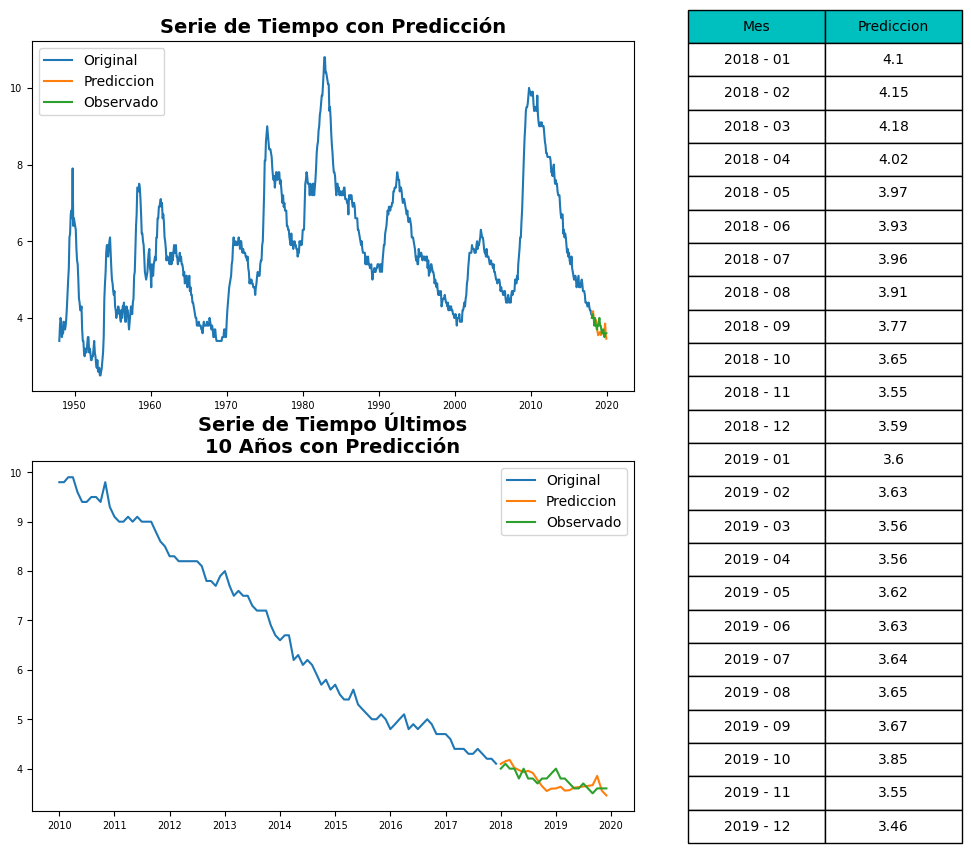

In [6]:
HWES1 = ExponentialSmoothing(
    df[["UNRATE"]],
    seasonal_periods=120,
    trend="add",
    seasonal="add",
    initialization_method="estimated").fit()

HWES1_fitted = HWES1.fittedvalues

mosaic = [["A", "A", "C"],["B", "B", "C"]]
fig, ax = plt.subplot_mosaic(mosaic, figsize = (12, 10))

ax["A"].plot(df[["UNRATE"]])
ax["A"].plot(HWES1.forecast(24))
ax["A"].plot(df_test.set_index("DATE")[["UNRATE"]])
ax["A"].legend(labels = ["Original", "Prediccion", "Observado"])

ax["B"].plot(df[["UNRATE"]][df[["UNRATE"]].shape[0]-96:])
ax["B"].plot(HWES1.forecast(24))
ax["B"].plot(df_test.set_index("DATE")[["UNRATE"]])
ax["B"].legend(labels = ["Original", "Prediccion", "Observado"])

Prediccion = pd.DataFrame(HWES1.forecast(24)).reset_index().rename({0:"Prediccion", "index":"Mes"}, axis = 1)
Prediccion["Mes"] = Prediccion["Mes"].apply(lambda x: dt.datetime.strftime(x, "%Y - %m"))
Prediccion["Prediccion"] = Prediccion["Prediccion"].apply(lambda x: np.round(x, 2))

ax["C"].table(
    cellText= Prediccion.values,
    colLabels=Prediccion.columns,
    loc = "center",
    cellLoc="center",
    colColours="cc"
).scale(1,2)

ax["C"].axis("off")
ax["A"].set_title("Serie de Tiempo con Predicción", fontweight = "bold")
ax["B"].set_title("Serie de Tiempo Últimos\n10 Años con Predicción", fontweight = "bold")
plt.show()

El error cuadrático medio del modelo fue de:

In [7]:
sum((HWES1.forecast(24) -df_test.set_index("DATE")["UNRATE"])**2)/len(HWES1.forecast(24))

0.028676865425327196